In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import pickle
import os

from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra, connected_components
from itertools import chain, combinations, product

from reeb_graph import Reeb_Graph
from reeb_aux import *

In [2]:
import networkx as nx
import pyomo.environ as pyo
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)


def circular_max_flow(reeb, circular=True):
    
    edges = reeb.E+1
    
    pts_bottom = np.unique(reeb.REEB_GRAPH[:,0])
    pts_bottom = pts_bottom[pts_bottom>-1]
    pts_top = np.unique(reeb.REEB_GRAPH[:,-1])
    pts_top = pts_top[pts_top>-1]

    add_edges_bottom = np.vstack([np.zeros_like(pts_bottom),pts_bottom + 1]).T
    add_edges_top = np.vstack([pts_top + 1, np.zeros_like(pts_top) + np.max(reeb.G.nodes) + 2]).T

    constr_edges = np.zeros((len(add_edges_bottom),4))
#    constr_edges = np.hstack([add_edges_bottom, add_edges_top])
    constr_edges[:,:2] = add_edges_bottom
    constr_edges[:,2:] = add_edges_top

    edges = np.vstack([add_edges_bottom,edges,add_edges_top])
        
    edges_to_idx = {}

    for e in edges:
        edges_to_idx[tuple(e)] = np.argmin(np.linalg.norm(edges-e,axis=-1)) 
        
    N = np.sum(reeb.D_reeb_w)
    cap = {}
    
    for e in reeb.E:
        cap[tuple(e+1)] = reeb.G.edges[tuple(e)]['capacity']
    
    for e in add_edges_bottom:
        cap[tuple(e)] = N

    for e in add_edges_top:
        cap[tuple(e)] = N
    
    cost = pyo.ConcreteModel()
    cost.n = len(edges) 

    cost.f = pyo.Var(np.arange(cost.n),
                     domain=pyo.NonNegativeReals,initialize=0)
    
    flow = sum([cost.f[edges_to_idx[(0,v+1)]] for v in pts_bottom]) 

    cost.obj=pyo.Objective(rule=flow, sense=pyo.maximize)
    cost.costr=pyo.ConstraintList()

    for e in edges:
        cost.costr.add(cost.f[edges_to_idx[tuple(e)]] <= cap[tuple(e)])

    if circular:
        for e in constr_edges:
            cost.costr.add(cost.f[edges_to_idx[tuple(e[:2])]] == cost.f[edges_to_idx[tuple(e[2:])]])


    for v in list(reeb.G.nodes):
        
        neigh = list(reeb.G[v])
        
        if v in pts_bottom:
            neigh = neigh+[-1]  
        elif v in pts_top:
            neigh = neigh+[np.max(reeb.G.nodes) + 1]  
            
        if len(neigh)>0:
            flx_in = sum([cost.f[edges_to_idx[(u+1,v+1)]] for u in neigh if u<v])
            flx_out = sum([cost.f[edges_to_idx[(v+1,u+1)]] for u in neigh if u>v])
            cost.costr.add(flx_in-flx_out==0)

    solver = pyo.SolverFactory('gurobi')
    S=solver.solve(cost)

    flx = cost.obj()

    f_eval = np.zeros_like(edges[:,0])

    for key,val in cost.f.extract_values().items():
                f_eval[key]=val 

    flow_eval = np.sum([f_eval[edges_to_idx[(0,v+1)]] for v in pts_bottom]) 
    
    return flow_eval

In [3]:
np.random.seed(17051991)

In [4]:
def poisson(lam,dim=3):
    
    n = np.random.poisson(lam=lam, size=(1,))[0]
    X = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
    
    return X


def matern_rep(lam,R,dim=3):

    n = np.random.poisson(lam=lam, size=(1,))[0]
    X = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
    t = np.random.uniform(low=0.0, high=1.0, size=(n,))
    
    D = squareform(pdist(X))
    
    order = np.argsort(t)
    
    idxs = np.ones_like(order)
    
    for i in order:
        if idxs[i]>0:
            idxs_aux_0 = D[i,:]<R 
            idxs_aux_1 = np.zeros_like(order)
            idxs_aux_1[i+1:] = 1
            
            idxs_aux = idxs_aux_0*idxs_aux_1
            
            idxs = idxs - idxs_aux
    
    idxs = idxs>0
    
    return X[idxs,:]


def matern_clust(lam_1,lam_2,R,dim=3):

    n = np.random.poisson(lam=lam_1, size=(1,))[0]
    P = np.random.uniform(low=0.0, high=1.0, size=(n,dim))
      
    p = P[0,:]
    n_p = np.random.poisson(lam=lam_2, size=(1,))[0]
    X = p+np.random.uniform(low=0.0, high=R, size=(n_p,dim))
    
    for p in P:
        n_p = np.random.poisson(lam=lam_2, size=(1,))[0]
        X_p = p+np.random.uniform(low=0.0, high=R, size=(n_p,dim))
        X = np.vstack([X,X_p])
        
    return X

In [39]:
from scipy.stats import multivariate_normal
from numba import jit, int32, prange

@jit(nopython=True, parallel=True, fastmath=True)
def make_line(p,q,n=10,dim=3):
    
    lam_ = np.linspace(0,1,n)
    
    line = np.zeros((n,dim))
    
    for i in range(n):
        line[i,:]= q*lam_[i] + (1-lam_[i])*p
    
    return line


@jit(nopython=True, parallel=True, fastmath=True)
def dens_eval(x,p, q, n=10,sigma=0.1,dim=3):
    
    line = make_line(p,q,n=n,dim=dim)
    out=np.zeros((n,1))
    
    for i in range(n):    
        mean = line[i,:]
        out[i]= np.exp(-np.linalg.norm((mean-x)/sigma)**2/2)
        
    return np.max(out)


@jit(nopython=True, parallel=True, fastmath=True)
def max_density(p, q, n=10, sigma=0.1,dim=3):

    line = make_line(p,q,n=n,dim=dim)
    m = np.zeros((n,))
    
    for i in range(n):
        x = line[i,:]
        m[i] = dens_eval(x,p, q, n=n, sigma=sigma,dim=dim)
    return np.max(m)

def inhom_poisson(p, q, lam=100,n=10,sigma=0.1,dim=3):
    
    K = np.max(max_density(p, q, n=n, sigma=sigma,dim=dim))
    
    X_tmp = poisson(lam,dim=dim)
    X = np.zeros_like(X_tmp)
    count = 0
    
#    DENS = [dens_eval(x,p, q, n=n,sigma=sigma,dim=3) for x in X_tmp]
#    plt.scatter(X_tmp[:,0],X_tmp[:,2],c=DENS)
#    plt.show()

    
    for i in range(len(X_tmp)):
        x = X_tmp[i,:]
        val = dens_eval(x,p, q, n=n,sigma=sigma,dim=dim)/K        
        
        coin = np.random.binomial(1,val)
        
        if coin>0:
            X[count,:]=x
            count+=1
        
    return X[:count,:]

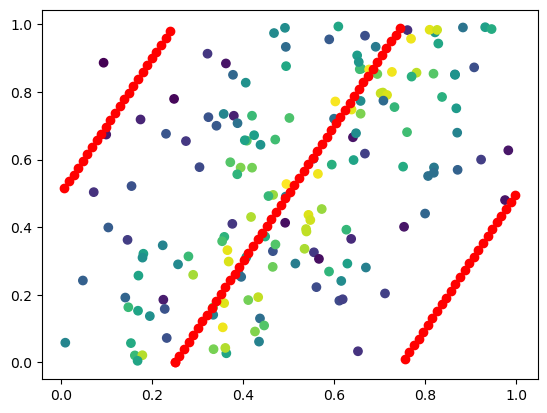

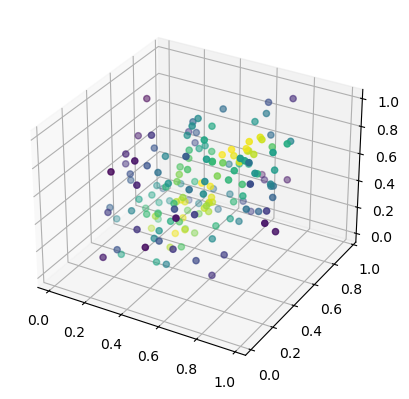

In [40]:
p = np.array([0.25,0.5,0])
q_ = np.array([1.25,0.5,2])
n = 100
sigma = 0.2
lam=500

X = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)
DENS = [dens_eval(x,p, q, n=n,sigma=sigma,dim=3) for x in X]
aux = max_density(p, q, n=n, sigma=sigma,dim=3)

L_ = make_line(p,q_,n=n,dim=3)
L_ = m + np.remainder(L_-m, M-m)


plt.scatter(X[:,0],X[:,2],c=DENS)
plt.scatter(L_[:,0],L_[:,2],c='r')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],c=DENS)

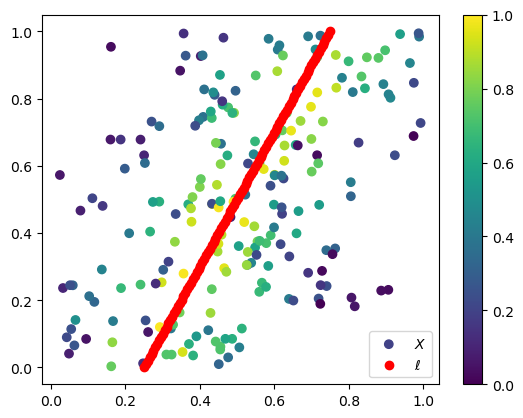

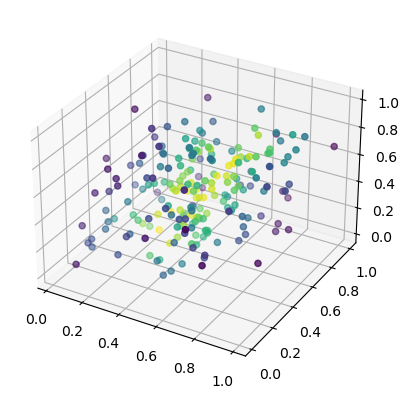

In [89]:
p = np.array([0.25,0.5,0])
q = np.array([0.75,0.5,1])
n = 100
sigma = 0.2
lam=800

X = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)
DENS = [dens_eval(x,p, q, n=n,sigma=sigma,dim=3) for x in X]
aux = max_density(p, q, n=n, sigma=sigma,dim=3)

L = make_line(p,q,n=n,dim=3)

plt.scatter(X[:,0],X[:,2],c=DENS, label='$X$')
plt.scatter(L[:,0],L[:,2],c='r', label='$\ell$')
plt.colorbar()
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],c=DENS)

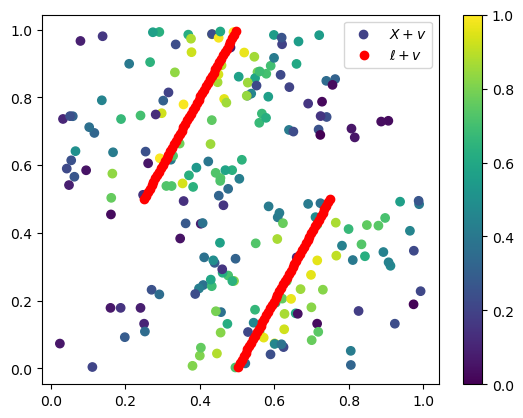

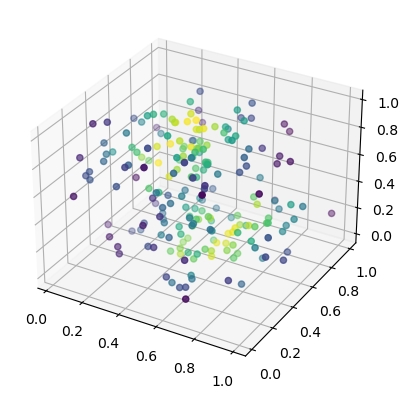

In [90]:
v = np.array([0,0,0.5])

X_aux = X+v
X_aux = m + np.remainder(X_aux-m, M-m)

L_aux = L+v
L_aux = m + np.remainder(L_aux-m, M-m)


plt.scatter(X_aux[:,0],X_aux[:,2],c=DENS, label='$X+v$')
plt.scatter(L_aux[:,0],L_aux[:,2],c='r', label='$\ell+v$')
plt.colorbar()
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_aux[:,0],X_aux[:,1],X_aux[:,2],c=DENS)

In [49]:
k = 0.07

r = radii*k 

reeb_ = Reeb_Graph(X_aux, M = M, m = m, radii = r,
    grid_size = n_grid, 
    periodic = True,
    fat_radius = fat,
    covering = covering,
    reeb_stride = reeb_stride,
#    transform_points = [np.identity(3),v],
    transform_points = None,
    swap_res_grid_and_balls = True,
    relax_z_axis = relax,
    verbose = False, save_RAM = True, stride=stride, MP=False)


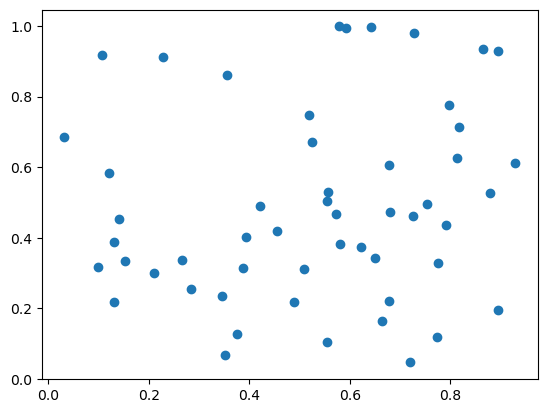

In [7]:
p = np.array([0.25,0])
q = np.array([0.75,1])
n = 100
sigma = 0.25

X = inhom_poisson(p, q, n=n,sigma=sigma,dim=2)

plt.scatter(X[:,0],X[:,1])

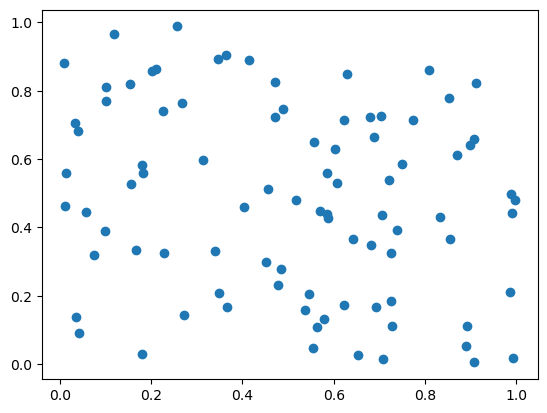

In [8]:
X = poisson(100,dim=2)

plt.scatter(X[:,0],X[:,1])

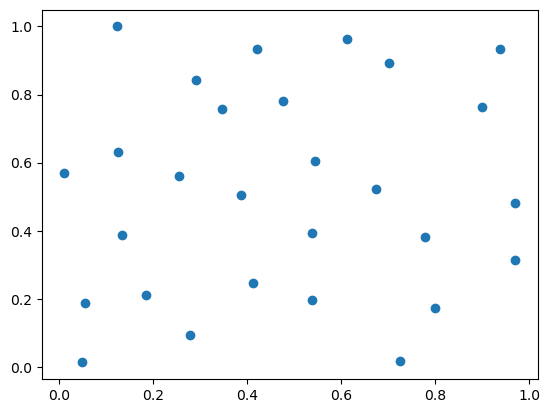

In [9]:
X = matern_rep(100,0.1,dim=2)

plt.scatter(X[:,0],X[:,1])

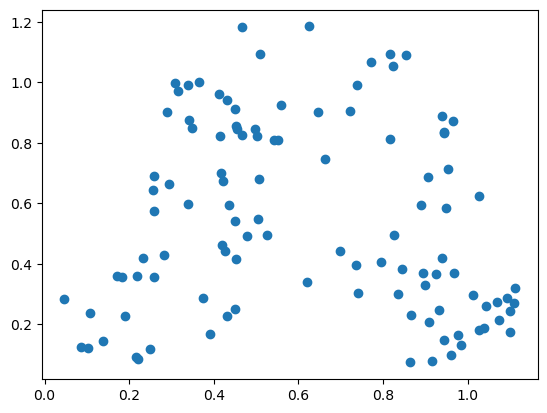

In [10]:
X = matern_clust(20,5,0.2,dim=2)

plt.scatter(X[:,0],X[:,1])

In [11]:
n_grid = 101
fat = 1
covering = np.array([-1,1])
reeb_stride = 2
relax = [n_grid//2,-(n_grid//2+1)]
stride = 20

M = np.array([1,1,1],dtype=float)
m = np.array([0,0,0],dtype=float)

lam = 100

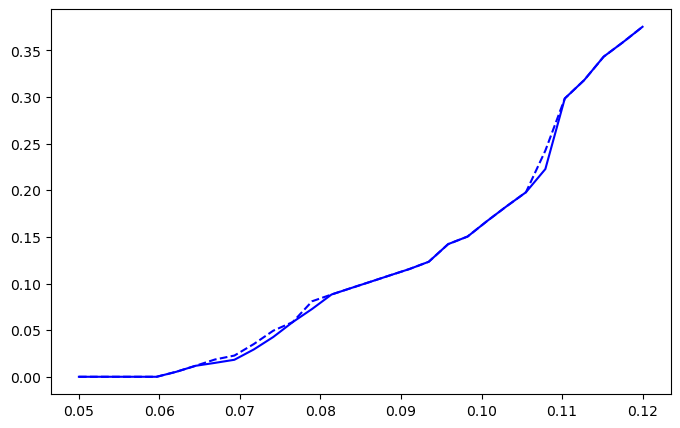

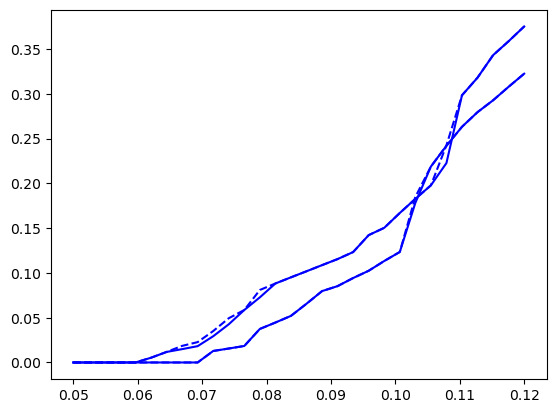

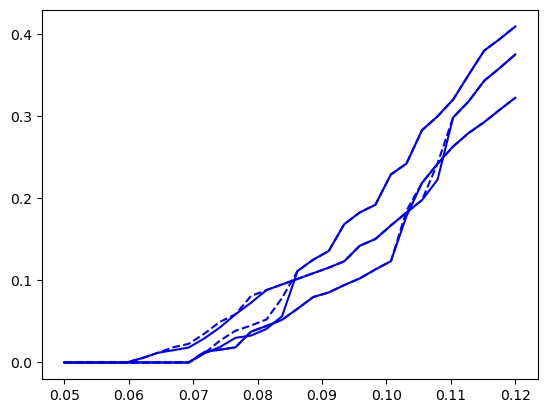

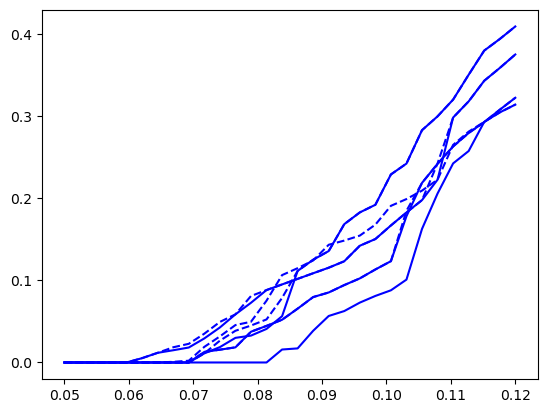

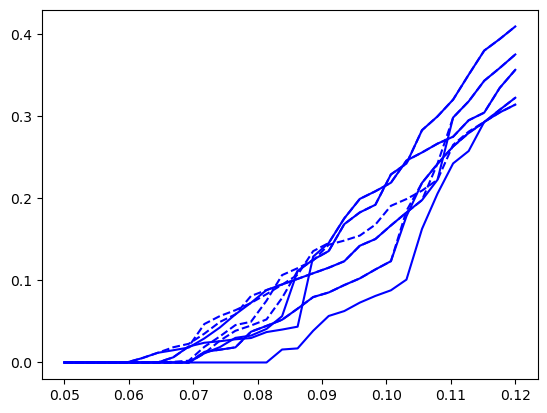

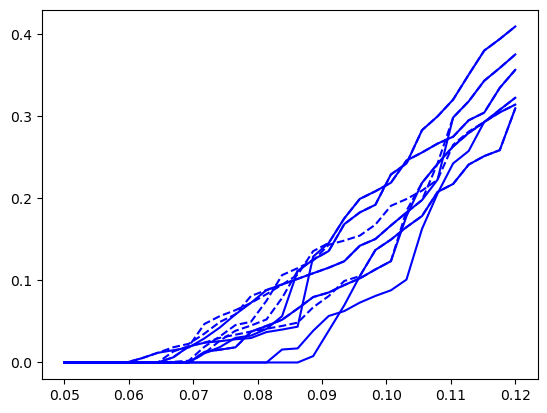

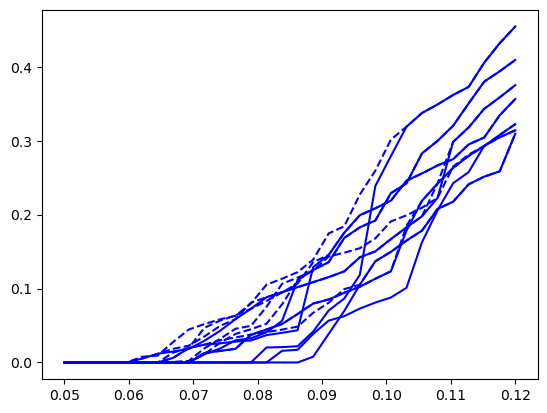

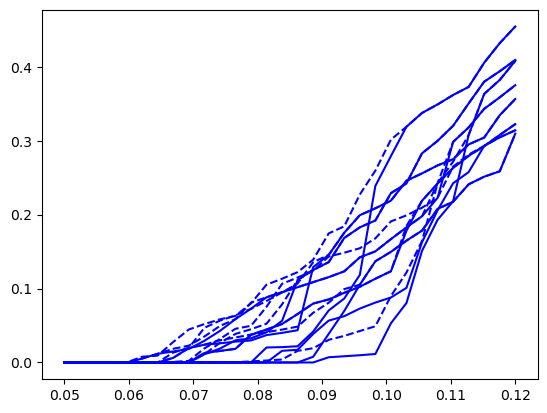

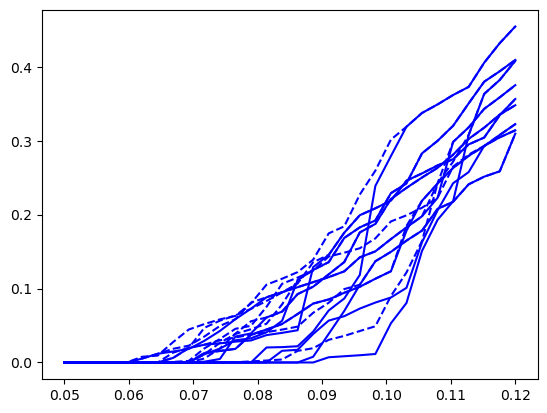

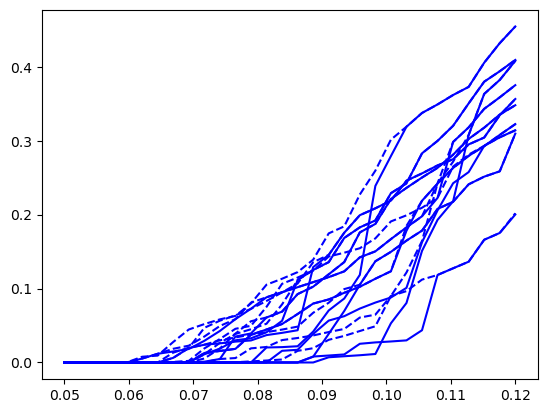

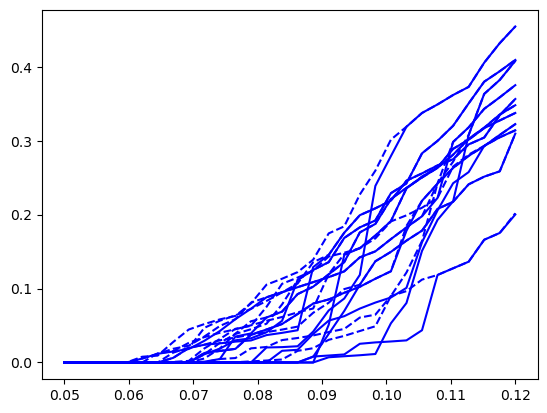

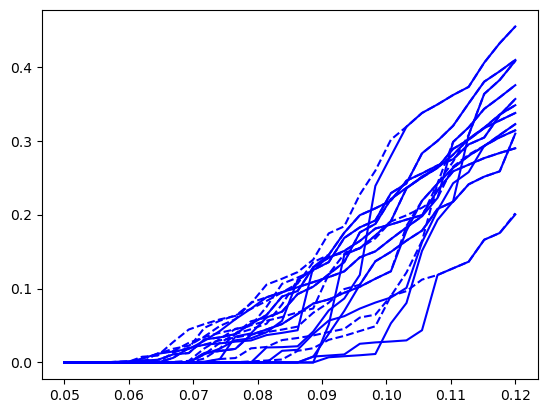

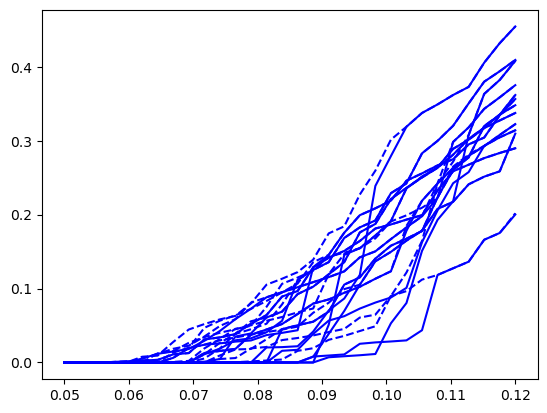

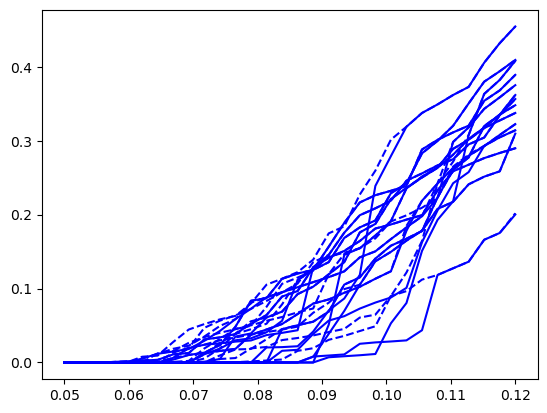

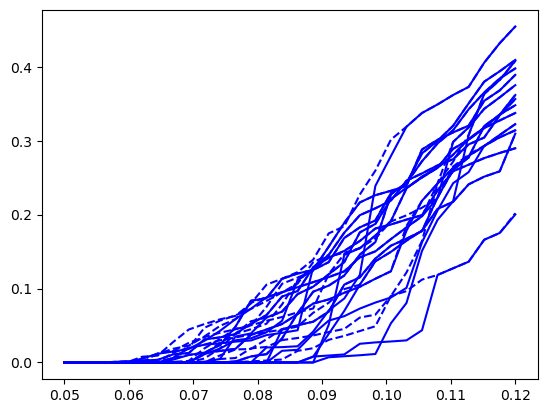

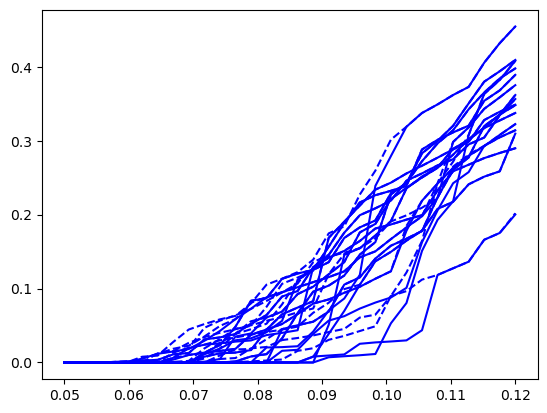

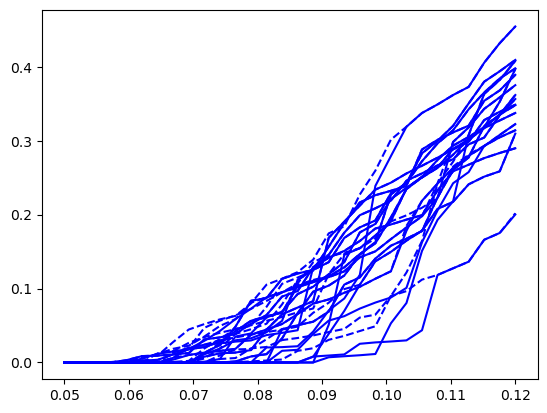

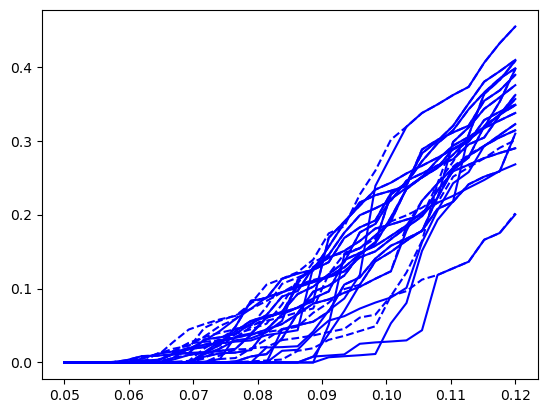

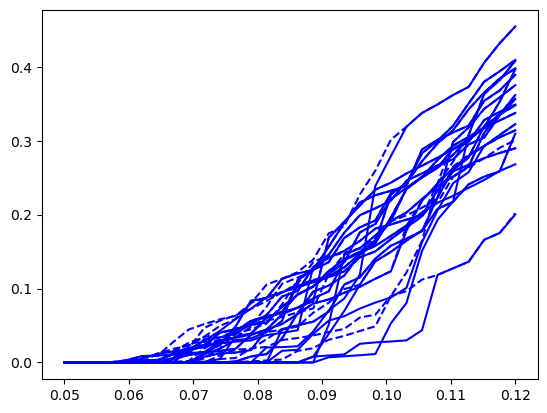

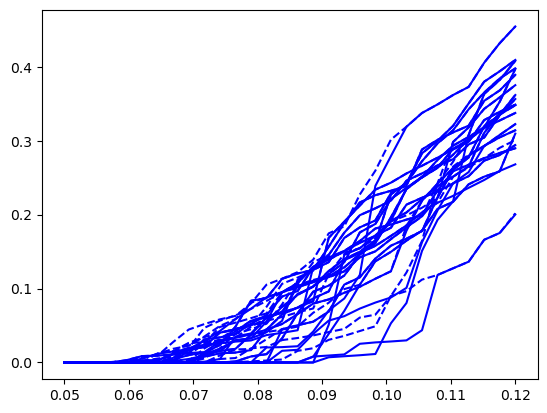

In [12]:
F = []
G = []
R = []

colors = ['b','r','g']
labels = ['CSR','Repulsive','Cluster']
r_grid = np.linspace(0.05,0.12,30)


plt.ion()
figure, ax = plt.subplots(figsize=(8, 5))
    
plt.isinteractive()

c = []

for count in range(20):
    for i in [3]:        

        if i ==0:
            X = poisson(400)
        elif i==1:
            X = matern_rep(400,0.2)
        elif i==2:
            X = matern_clust(50,10,0.1)
        else:
            p = np.array([0.25,0.5,0])
            q = np.array([0.75,0.5,1])
            n = 100
            sigma = 0.2
            lam=800

            X = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)

        f = []
        g = []
        r_aux = []
        radii = np.ones_like(X[:,0])

        for j,k in enumerate(r_grid):

            r = radii*k 

            reeb = Reeb_Graph(X, M = M, m = m, radii = r,
                grid_size = n_grid, 
                periodic = True,
                fat_radius = fat,
                covering = covering,
                reeb_stride = reeb_stride,
                transform_points = None,
                swap_res_grid_and_balls = True,
                relax_z_axis = relax,
                verbose = False, save_RAM = True, stride=stride, MP=False)

            if reeb.res_grid is not None:
                reeb.make_reeb_graph(plot=False)
                try:
                    cflow = circular_max_flow(reeb)*(reeb.unit_2d)
                    flow = circular_max_flow(reeb,False)*(reeb.unit_2d)
                except:
                    print('Ho fallito: ', v,i,j)
                    cflow=0
                    flow=0
            else: 
                cflow=0
                flow=0

            print('Reeb Graph Done! Iteration: ', count,' Class: ',i,' Radius: ', k,
                  ' Flows: ',cflow,flow,'       ',end='\r')
            
            f.append(cflow)
            g.append(flow)
            r_aux.append(k)
            
            if np.abs(cflow - flow)<0.0001 and cflow<0:                
                break
                
        f = np.array(f)
        g = np.array(g)
        r_aux = np.array(r_aux)

        F.append(f)
        G.append(g)
        R.append(r_aux)

        for j,f in enumerate(F):
            plt.plot(R[j],f,c=colors[0])

        for j,g in enumerate(G):
            plt.plot(R[j],g,c=colors[0],linestyle='dashed')

        plt.show()

np.save('Circular',F)
np.save('Source_Target',G)
np.save('Radii',R)

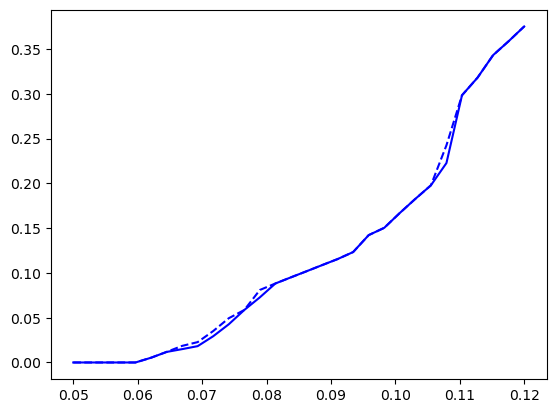

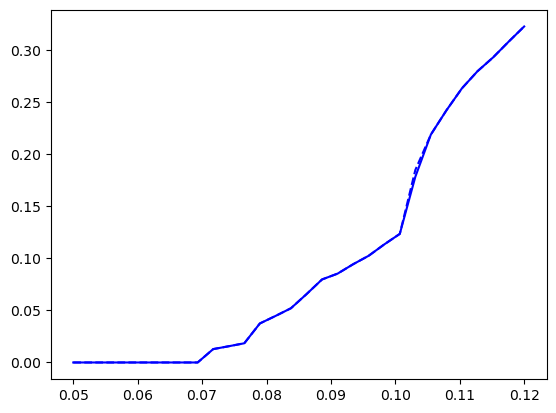

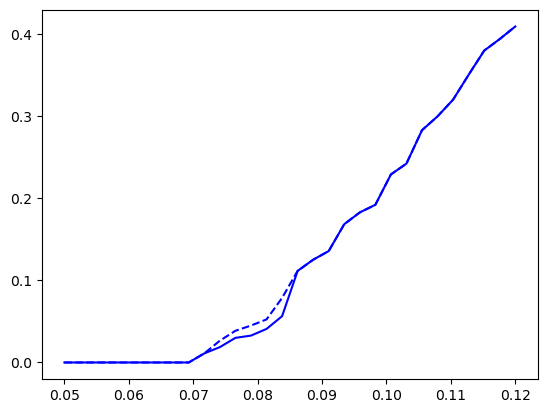

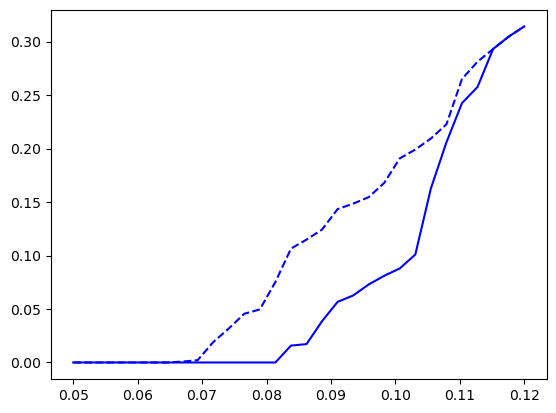

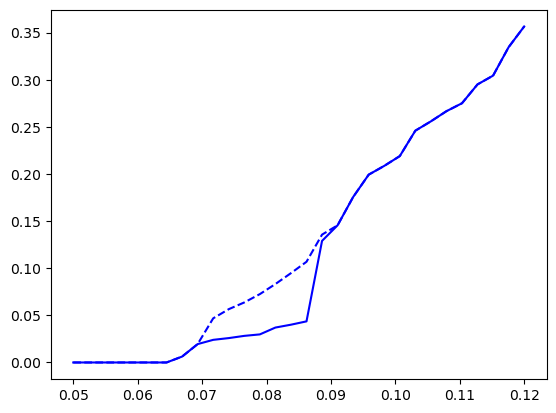

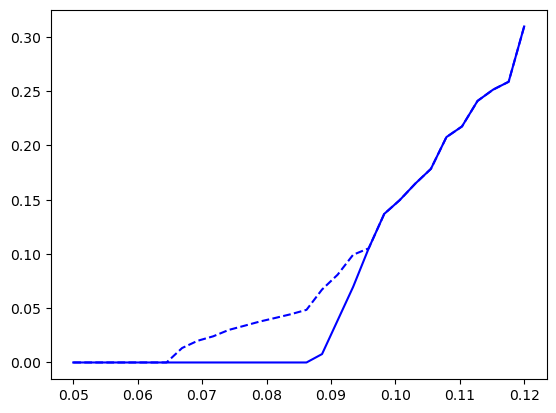

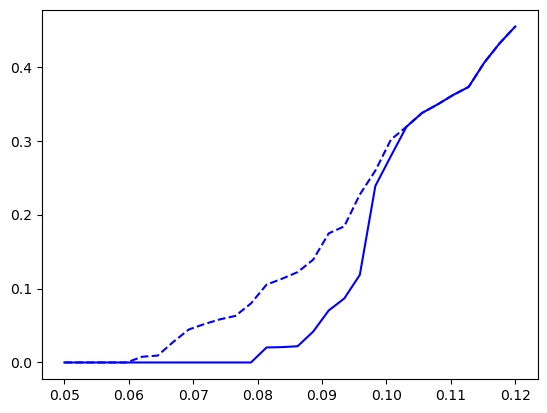

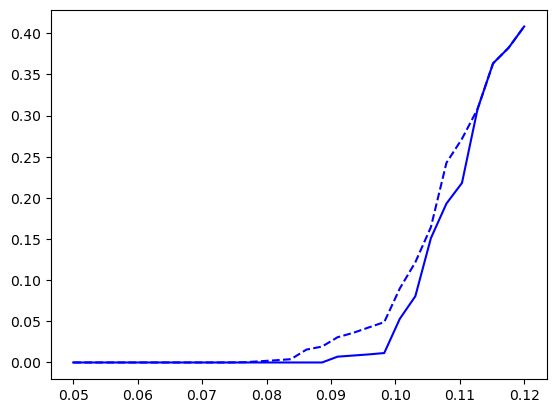

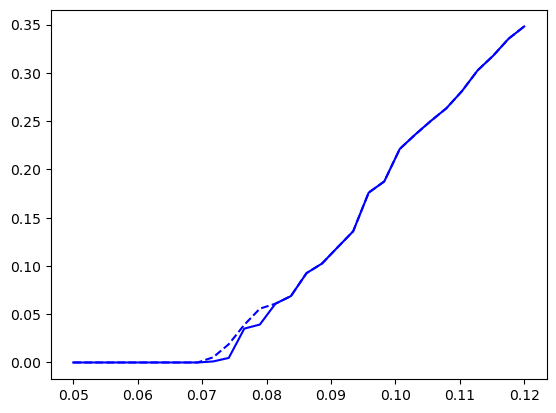

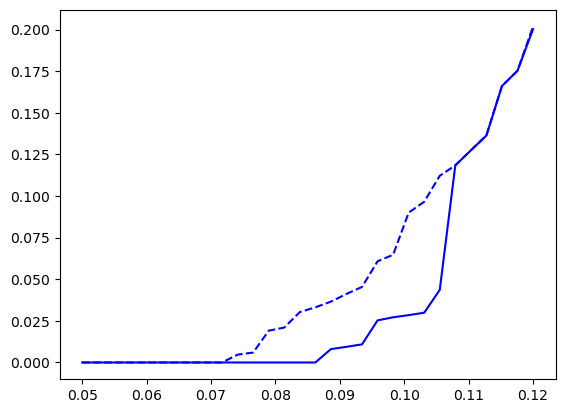

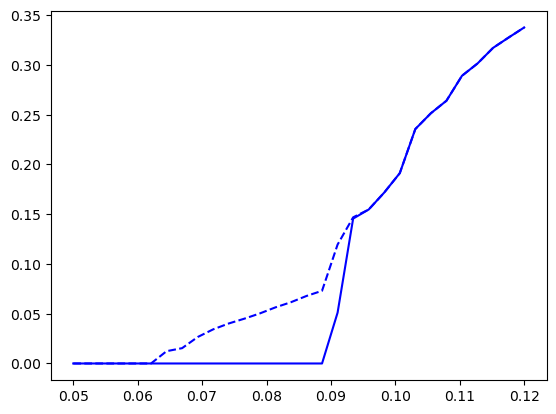

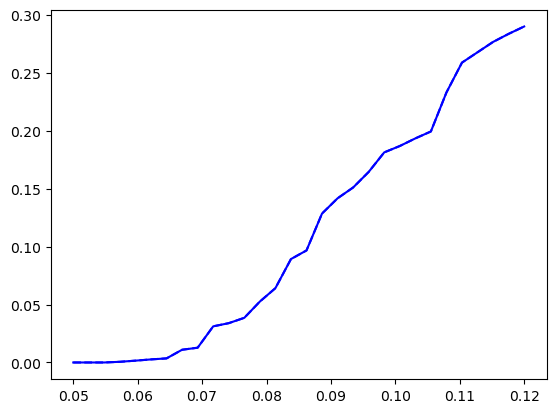

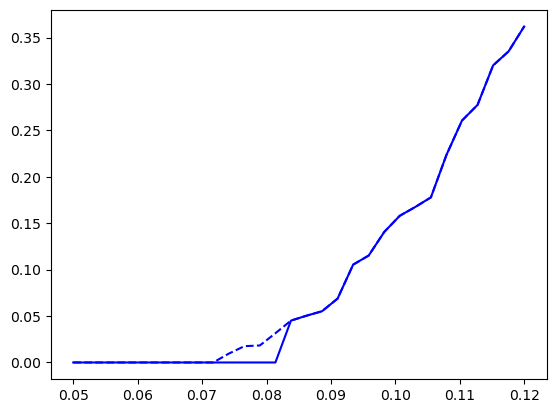

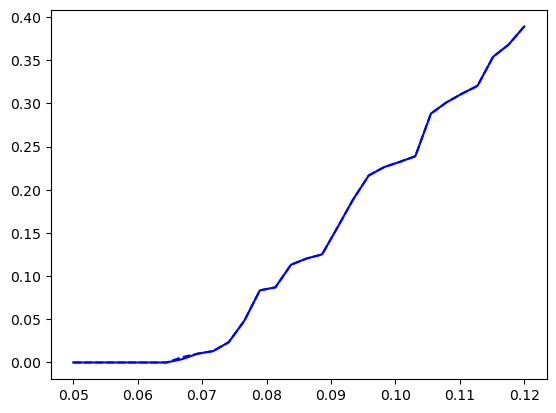

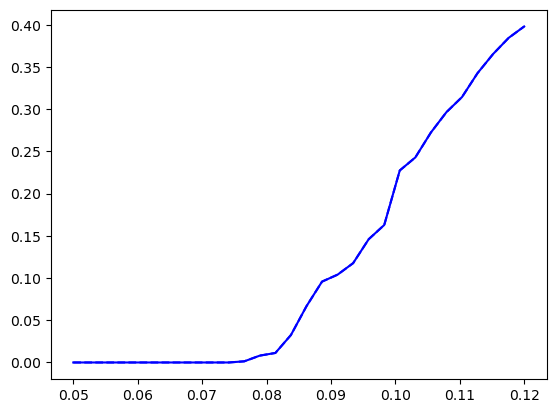

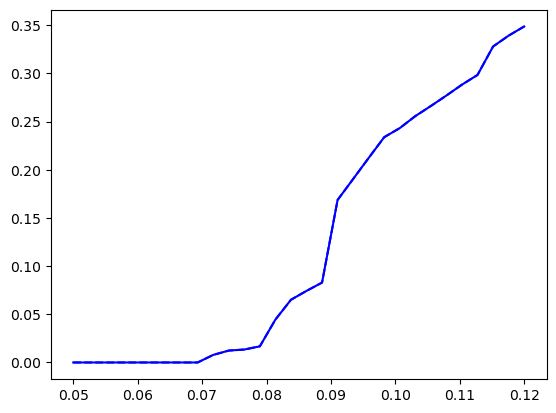

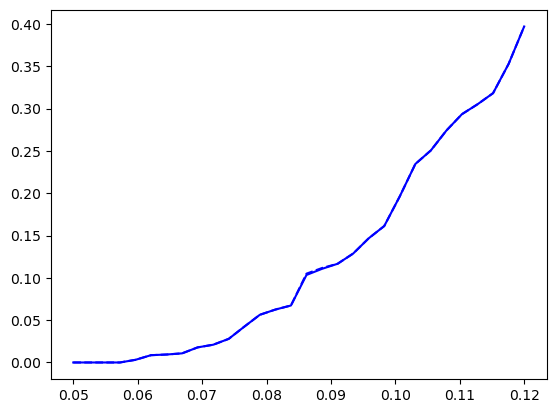

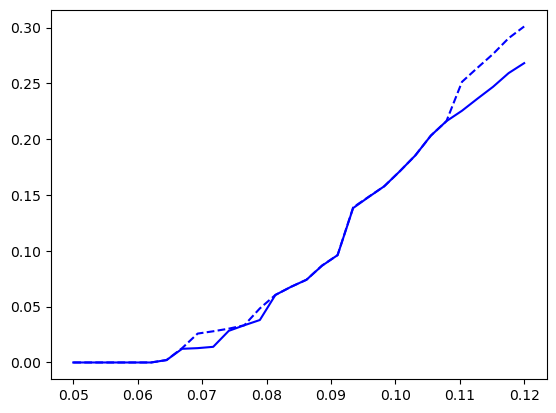

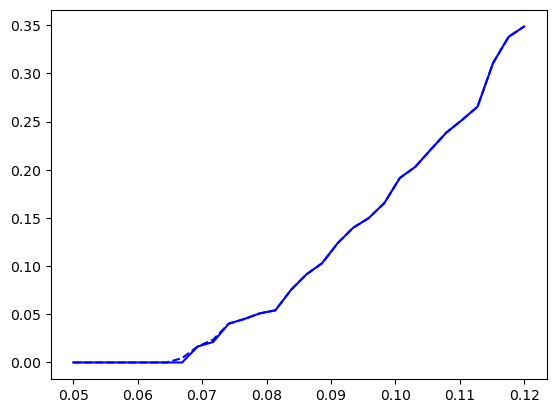

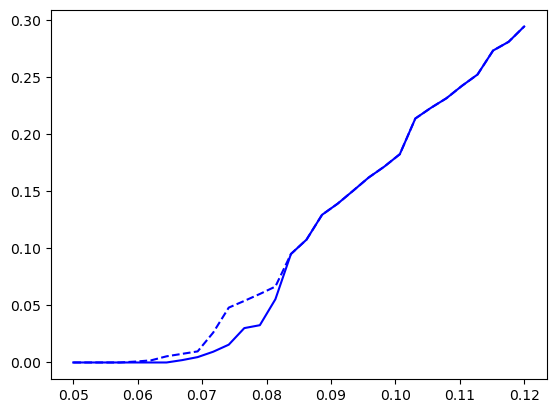

In [30]:
for j in range(len(F)):
    f = F[j]
    g = G[j]

    plt.plot(R[j],f,c=colors[0])
    plt.plot(R[j],g,c=colors[0],linestyle='dashed')

    plt.show()


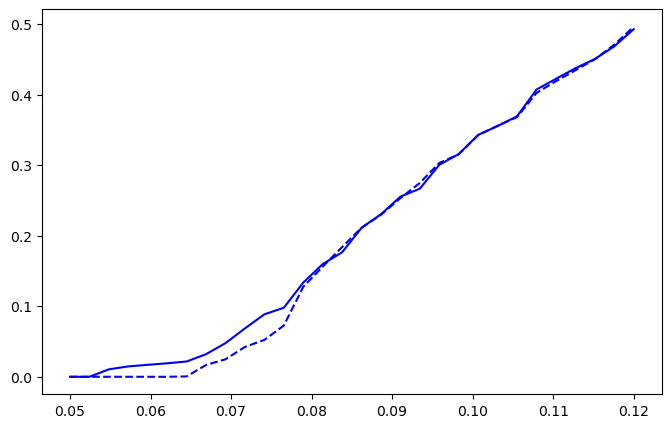

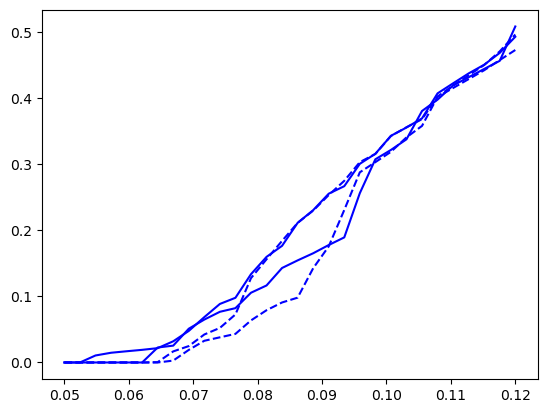

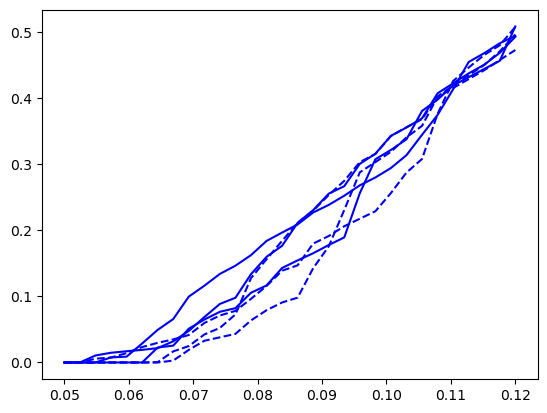

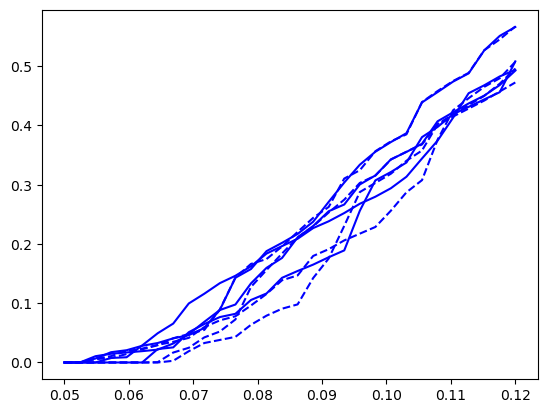

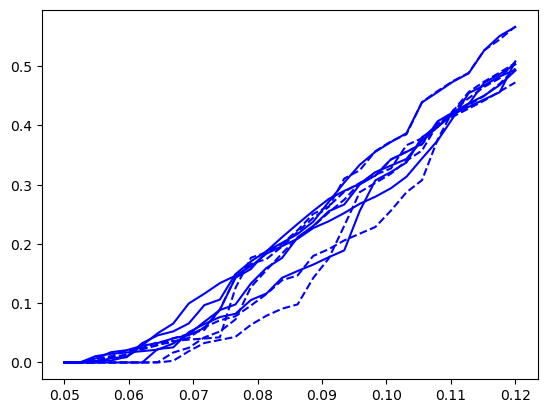

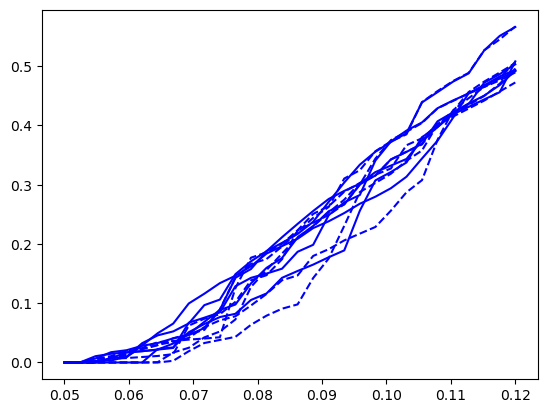

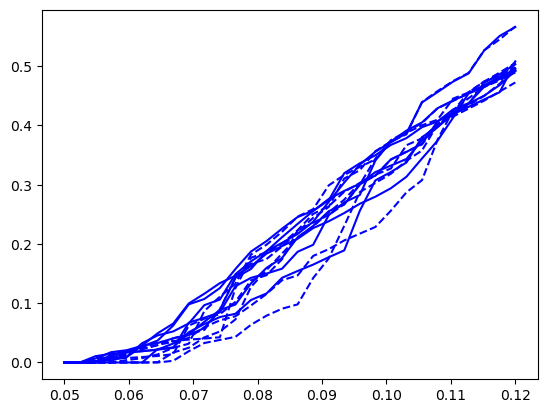

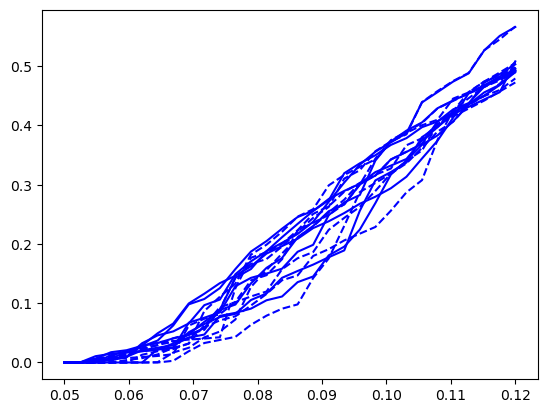

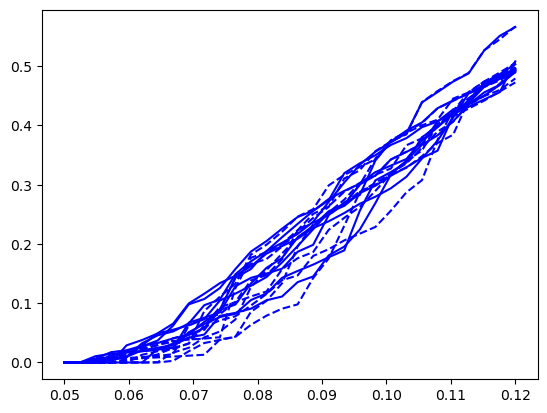

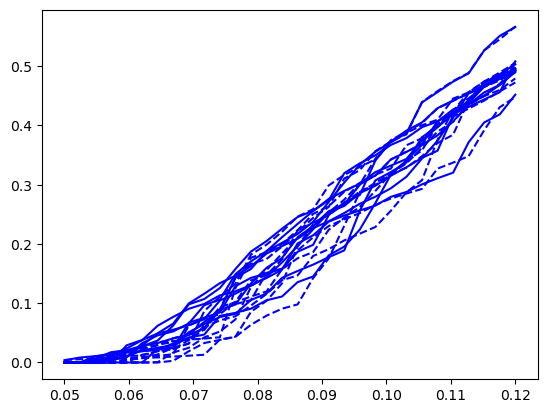

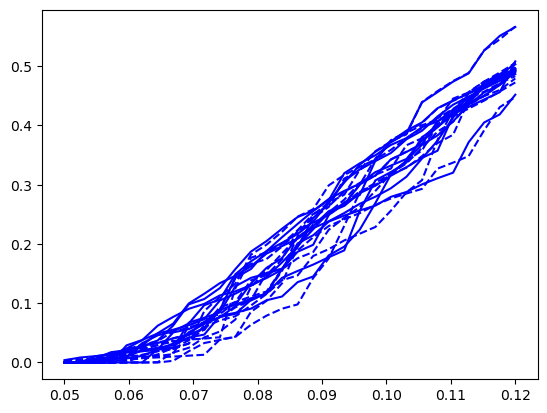

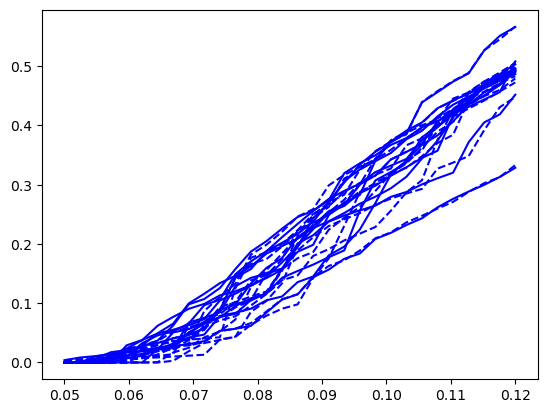

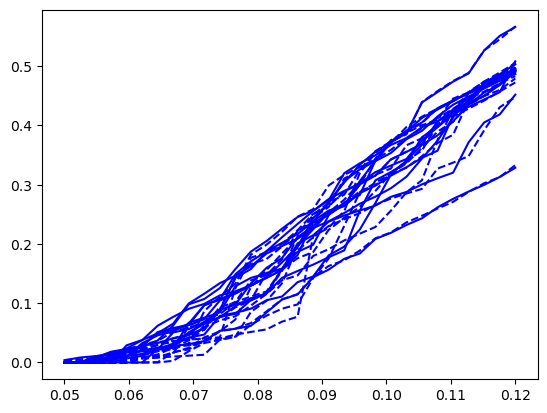

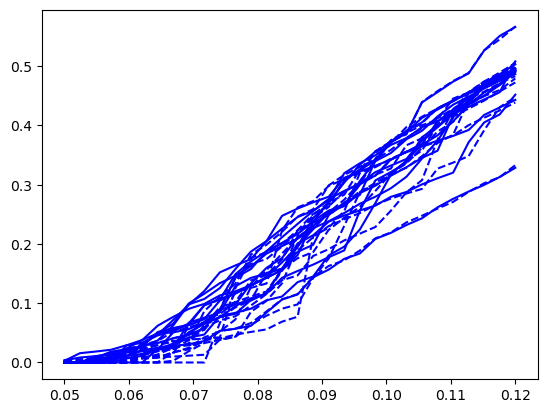

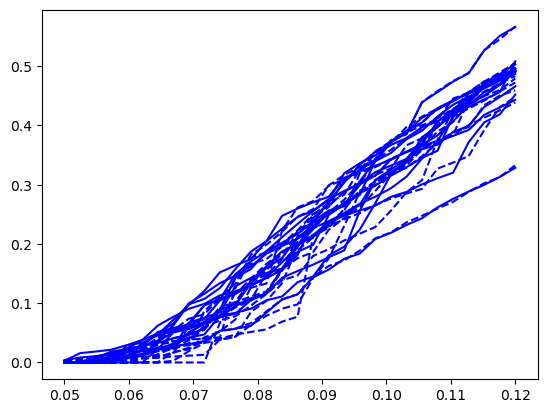

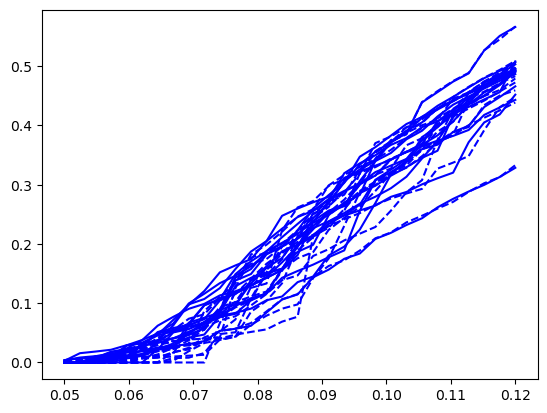

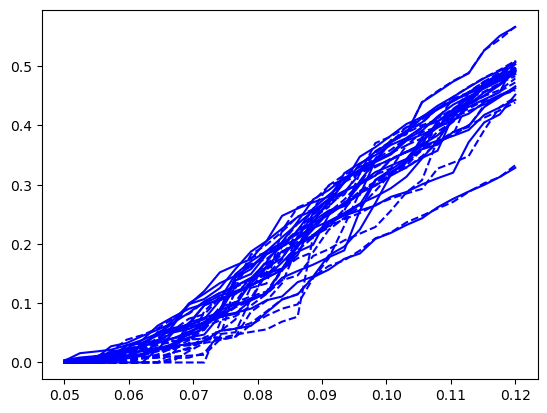

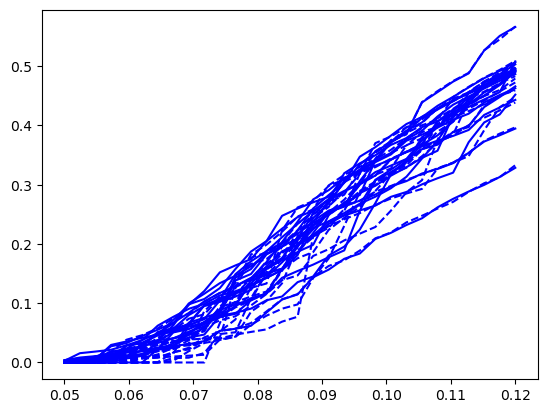

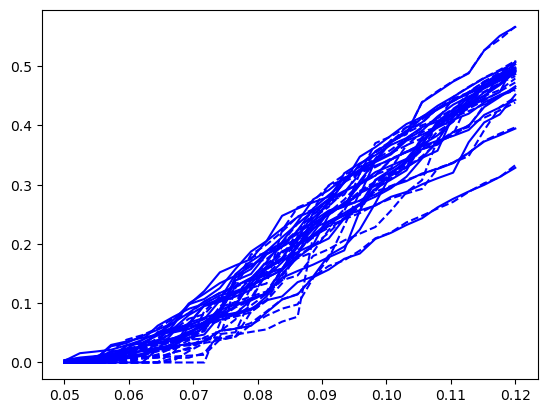

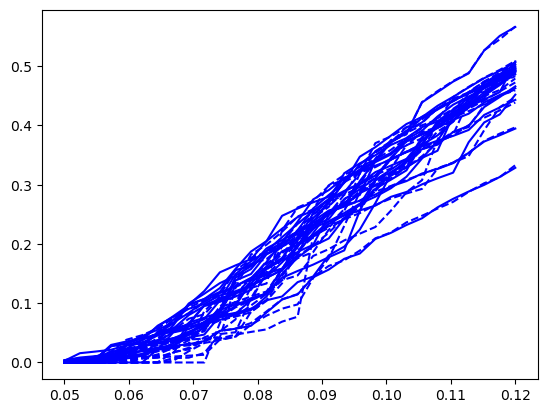

In [52]:
F = []
G = []
R = []

colors = ['b','r','g']
labels = ['CSR','Repulsive','Cluster']
r_grid = np.linspace(0.05,0.12,30)


plt.ion()
figure, ax = plt.subplots(figsize=(8, 5))
    
plt.isinteractive()

c = []

for count in range(20):

        p = np.array([0.25,0.5,0])
        q = np.array([0.75,0.5,1])
        n = 100
        sigma = 0.2
        lam=800

        X_ = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)
        
        v = np.array([0,0,0.5])
        X_aux = X_+v
        X_aux = m + np.remainder(X_aux-m, M-m)

        f = []
        g = []
        r_aux = []
        radii = np.ones_like(X_[:,0])
        
        tmp =[f,g]
        
        for i,X in enumerate([X_,X_aux]):
        
            for j,k in enumerate(r_grid):

                r = radii*k 

                reeb = Reeb_Graph(X, M = M, m = m, radii = r,
                    grid_size = n_grid, 
                    periodic = True,
                    fat_radius = fat,
                    covering = covering,
                    reeb_stride = reeb_stride,
                    transform_points = None,
                    swap_res_grid_and_balls = True,
                    relax_z_axis = relax,
                    verbose = False, save_RAM = True, stride=stride, MP=False)

                if reeb.res_grid is not None:
                    reeb.make_reeb_graph(plot=False)
                    try:
                        flow = circular_max_flow(reeb,False)*(reeb.unit_2d)
                    except:
                        print('Ho fallito: ', v,i,j)
                        flow=0
                else: 
                    flow=0

                print('Reeb Graph Done! Iteration: ', count,' Periodicity: ',i,' Radius: ', k,
                      ' Flow: ',flow,'                  ',end='\r')
            
                tmp[i].append(flow)
            
                if i==0:
                    r_aux.append(k)
            
        f = np.array(tmp[0])
        g = np.array(tmp[1])
        r_aux = np.array(r_aux)

        F.append(f)
        G.append(g)
        R.append(r_aux)

        for j,f in enumerate(F):
            plt.plot(R[j],f,c=colors[0])

        for j,g in enumerate(G):
            plt.plot(R[j],g,c=colors[0],linestyle='dashed')

        plt.show()



In [53]:
np.save('Source_Target',F)
np.save('Source_Target_v',G)
np.save('Radii',R)

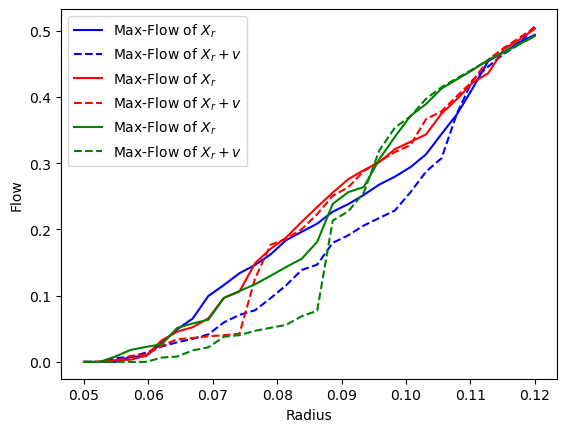

In [99]:
    
f = F[2]
g = G[2]
plt.plot(R[2],f,c=colors[0], label='Max-Flow of $X_r$')
plt.plot(R[2],g,c=colors[0],linestyle='dashed', label='Max-Flow of $X_r+v$')


f = F[4]
g = G[4]
plt.plot(R[3],f,c=colors[1], label='Max-Flow of $X_r$')
plt.plot(R[3],g,c=colors[1],linestyle='dashed', label='Max-Flow of $X_r+v$')


f = F[12]
g = G[12]
plt.plot(R[12],f,c=colors[2], label='Max-Flow of $X_r$')
plt.plot(R[12],g,c=colors[2],linestyle='dashed', label='Max-Flow of $X_r+v$')

plt.xlabel('Radius')
plt.ylabel('Flow')

plt.legend()
plt.show()

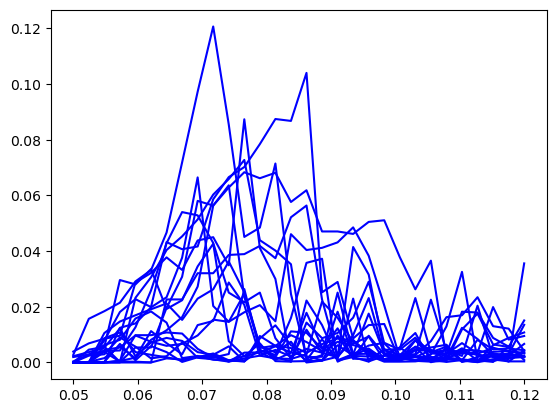

In [68]:
SUP_r = np.zeros((len(F),len(F[0])))

for j in range(len(F)):
    
    f = F[j]
    g = G[j]
    plt.plot(R[j],np.abs(f-g),c=colors[0])
    
    SUP.append(np.max(np.abs(f-g)))
    
    SUP_r[j,:] = np.abs(f-g)

In [69]:
np.mean(SUP)

0.04943632977159102

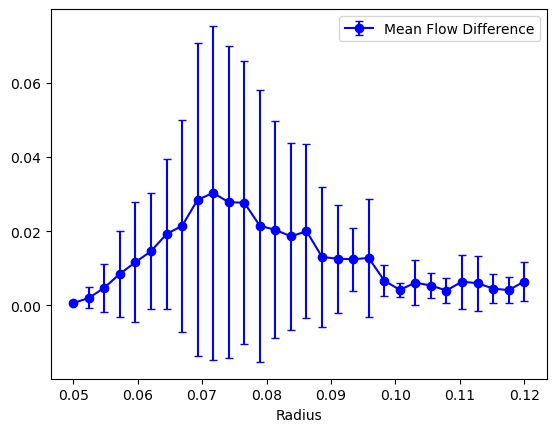

In [101]:
#err = np.var(SUP_r,axis=0)
plt.xlabel('Radius')
#plt.ylabel('Flow Difference')

plt.errorbar(R[j],np.mean(SUP_r,axis=0),yerr=err,c=colors[0],fmt='-o',capsize=3, label='Mean Flow Difference')
plt.legend()    

In [74]:
q75, q25 = np.percentile(SUP_r, [75 ,25], axis=0)

In [76]:
err = q75- q25

In [ ]:
np.save('Circular',F)
np.save('Source_Target',G)
np.save('Radii',R)